Etiquetas de clase  [0, 1]
columnas categoricas ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive']
Columnas numericas ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male', 'alone']
15
Instancia correspondiente a explicar x = { survived: 0,pclass = 3, age = 21.0, sibsp = 0, parch = 0, fare = 7.7333, adult_male = True, alone = True, 
sex = male, embarked = Q, class = Third, who = man, deck = C, embark_town = Queenstown, alive = no, }
Clase correspondiente a la predicción de black box bb(x) = { 0 }
Explicaión de LORE :
Reglas de Decisión --> r
Reglas contrafácticas --> c
r = { alive != yes } --> { survived: 0 }
c = { { alive = yes, embark_town = Cherbourg },
      { alive = yes, class = First },
      { alive = yes, who = woman },
      { alive = yes, alive != no } }
Aplicando las reglas contrafactacticas a la instancia x .....
La regla contrafactual cambió la clasificación , la prediccion es: [1]


100%|██████████| 100/100 [00:01<00:00, 59.50it/s]


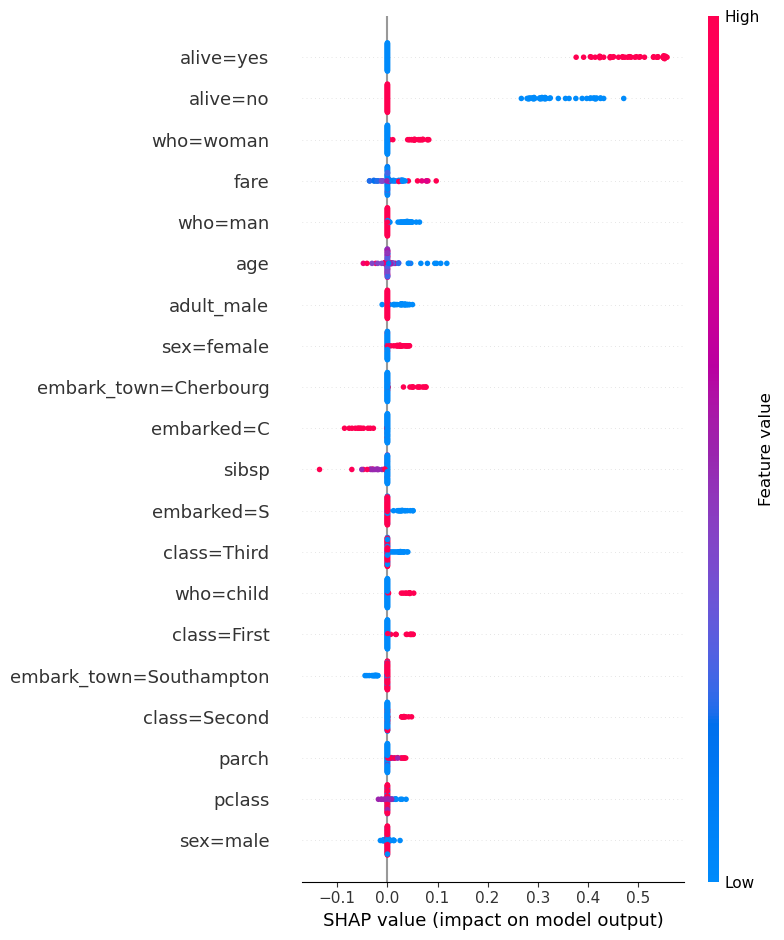

Metricas para el modelo:
Precisión 1.000
Medida F1 1.000


100%|██████████| 100/100 [00:03<00:00, 25.87it/s]


Fidelidad LORE Pre-Perturbación: 0.97336211505893
Fidelidad LORE Post-Perturbación: 0.9783671773337631
Fidelidad LIME Pre-Perturbación: 1.0
Fidelidad LIME Post-Perturbación: 1.0
Fidelidad SHAP Pre-Perturbación: 1.0
Fidelidad SHAP Post-Perturbación: 0.58


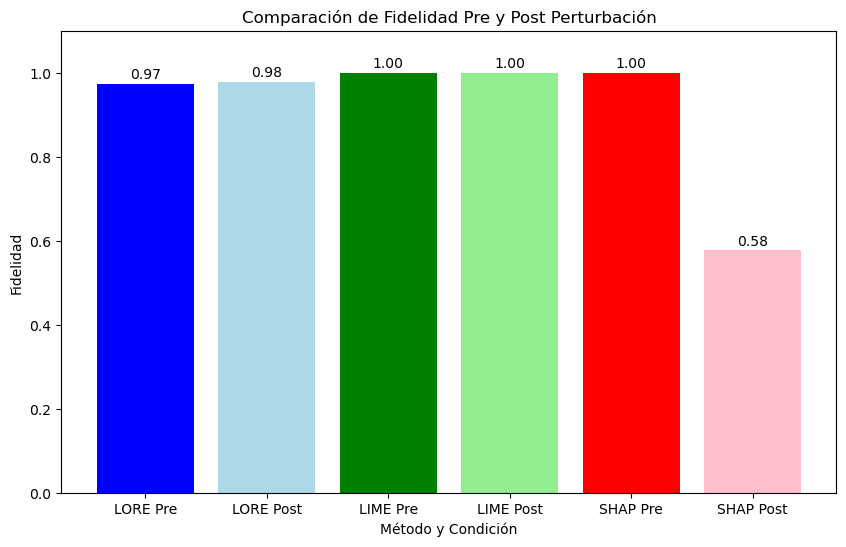

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random
from random import randint, uniform
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score , roc_curve, auc
from sklearn.tree import export_graphviz
from lore.lore import LORE , Explanation
from lore.decision_tree import *
from lore.distance import normalized_euclidean_distance
import graphviz
from lore.util import record2str
from lore.prepare_dataset import prepare_coinf_dataset, prepare_dataset , prepare_breast_cancer_dataset ,prepare_iris_dataset , prepare_titanic_dataset
from lore.rule import get_instances_covered_by_rule , apply_counterfactual
from lime.lime_tabular import LimeTabularExplainer
import shap
import plotly.graph_objects as go
from sklearn.metrics.pairwise import euclidean_distances
from lore.rule import get_depth

# PROCESAMIENTO DE DATOS
# Cargar y preparar el conjunto de datos
df, class_name = prepare_coinf_dataset("coinf.csv")
# Procesar el conjunto de datos para análisis
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataset(df, class_name)
print("Etiquetas de clase ", class_values)

#Obtener columnas discretas 
def get_categorical_columns(df, numeric_columns):
    categorical_columns = [col for col in df.columns if col not in numeric_columns]
    return categorical_columns

# Luego, obtén las columnas categóricas
categorical_columns = get_categorical_columns(rdf, numeric_columns)
print("columnas categoricas",categorical_columns)
print("Columnas numericas",numeric_columns)
print(len(categorical_columns)+len(numeric_columns))
# Establecer tamaño de prueba y estado aleatorio para la división de datos
test_size = 0.30
random_state = 0

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names].values, df[class_name].values, test_size=test_size, random_state=random_state, stratify=df[class_name].values)

# División adicional para análisis LORE
_, K, _, _ = train_test_split(rdf[real_feature_names].values, rdf[class_name].values, test_size=test_size, random_state=random_state, stratify=df[class_name].values)

# BLACK BOX
# Definición de parámetros para la búsqueda de hiperparámetros
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Inicialización y configuración del clasificador MLP
mlp = MLPClassifier(max_iter=100, random_state=random_state)
bb = GridSearchCV(mlp, parameter_space, n_jobs=1, cv=3)
bb.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros
best_params = bb.best_params_
# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
for param in best_params:
    print(f"{param}: {best_params[param]}")

# Funciones para realizar predicciones y obtener probabilidades de predicción
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

# Selección y análisis de una instancia específica
i2e = 1
x = X_test[i2e]
value = class_value = df.loc[i2e, class_name]
print('Instancia correspondiente a explicar x = %s' % record2str(x, feature_names, numeric_columns, class_name, value))

# Predecir la clase de la instancia seleccionada y mostrar el resultado
bb_outcome = bb_predict(x.reshape(1, -1))[0]
bb_outcome_str = class_values[bb_outcome]
print('Clase correspondiente a la predicción de black box bb(x) = { %s }' % bb_outcome_str)


#LORE
lore_explainer = LORE(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                       neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                       size=1000, ocr=0.1, random_state=random_state, ngen=10, bb_predict_proba=bb_predict_proba, 
                       verbose=False)
exp,weights,Z,Yb ,dt = lore_explainer.explain_instance(x, samples=1000, use_weights=True, metric=normalized_euclidean_distance)
print("Explicaión de LORE :")
print('Reglas de Decisión --> r\nReglas contrafácticas --> c' )
print(exp)

covered_indexes = get_instances_covered_by_rule(df[feature_names].values,exp.rule, feature_names, numeric_columns)

# print("Índices de instancias que cumplen con la regla:", covered_indexes)

# Extracción de las instancias cubiertas
covered_instances = df[feature_names].iloc[covered_indexes]

# print('Instancias cubiertas por la regla de decisión:')
# for index, instance in covered_instances.iterrows():
#     print(f'Índice {index}: {instance.to_dict()}')

#Aplicando las contrafactuales a X
print("Aplicando las reglas contrafactacticas a la instancia x .....")
flat_deltas = [condition for sublist in exp.deltas for condition in sublist]
# Supongamos que 'x' es tu instancia y 'rule' es una regla contrafactual generada
modified_instance = apply_counterfactual(x, flat_deltas, feature_names, features_map, lore_explainer.features_map_inv, numeric_columns)
predicted_class = bb.predict(modified_instance.reshape(1, -1))
original_class = bb.predict(x.reshape(1, -1))
if original_class != predicted_class:
    print("La regla contrafactual cambió la clasificación , la prediccion es:",predicted_class)
else:
    print("La regla contrafactual no fue efectiva, la prediccion es :",predicted_class)
    
# print("x modificada con contrafactuales",modified_instance)    


class_names_str = [str(cls) for cls in class_values]

# # Poda los nodos con pocas muestras y visualiza el árbol
# dt = learn_local_decision_tree(Z, Yb, weights, class_values, poda_tree=True)

# Asegúrate de que estás usando el árbol correcto después de la poda
assert dt.tree_.children_left[0] != TREE_LEAF  # La raíz no debe ser una hoja

# Exporta el árbol al formato Graphviz
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names_str,
    filled=True,
    rounded=True,
    special_characters=True
)

# Genera el gráfico usando Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")



#Importancia de las caracteristicas para LORE
# importances = dt.feature_importances_
# importance_feature_lore = dict(zip(feature_names, importances))
# print(importance_feature_lore)
# def get_feature_levels(dt, feature_names):
#     """
#     Encuentra los niveles de las características en un árbol de decisión.

#     :param dt: Árbol de decisión.
#     :param feature_names: Lista de nombres de las características.
#     :return: Diccionario con los niveles de cada característica.
#     """
#     n_nodes = dt.tree_.node_count
#     children_left = dt.tree_.children_left
#     children_right = dt.tree_.children_right
#     features = dt.tree_.feature

#     feature_levels = {name: [] for name in feature_names}
#     stack = [(0, 0)]  # nodo raíz y su nivel

#     while stack:
#         node_id, level = stack.pop()
#         # Si no es una hoja, actualizar la información de la característica
#         if children_left[node_id] != children_right[node_id]:
#             feature_name = feature_names[features[node_id]]
#             feature_levels[feature_name].append(level)

#             # Agregar nodos hijos a la pila
#             stack.append((children_left[node_id], level + 1))
#             stack.append((children_right[node_id], level + 1))

#     return feature_levels

# def calculate_feature_importance_from_tree(dt, importance_per_level, feature_names):
#     # Inicializar todos los nombres de características con importancia 0
#     feature_importance = {feature: 0 for feature in feature_names}
#     feature_levels = get_feature_levels(dt, feature_names)

#     for feature, levels in feature_levels.items():
#         for level in levels:
#             importance = importance_per_level.get(level, 0)
#             feature_importance[feature] += importance

#     return feature_importance


# # Calcula la profundidad máxima del árbol de decisión
# max_depth = get_depth(dt)

# # Crea el diccionario `importance_per_level` con la profundidad máxima
# def calculate_normalized_importance_per_level(max_depth):
#     # Asignar mayor importancia a niveles más bajos (cercanos a la raíz)
#     raw_importances = {i: max_depth - i for i in range(max_depth)}
    
#     # Normalizar las importancias para que estén en el rango de 0 a 1
#     total_importance = sum(raw_importances.values())
#     normalized_importances = {level: imp / total_importance for level, imp in raw_importances.items()}
    
#     return normalized_importances

# importance_per_level = calculate_normalized_importance_per_level(max_depth)

# # Calcula las importancias de las características
# feature_importances_lore = calculate_feature_importance_from_tree(dt, importance_per_level, feature_names)

# # Imprime las importancias calculadas
# print("Importancias de las características:", feature_importances_lore)
#LIME
lime_explainer = LimeTabularExplainer(X_test, feature_names=feature_names,class_names=class_values, discretize_continuous=False)
expLime = lime_explainer.explain_instance(x, bb_predict_proba)
expLime.show_in_notebook()
def modify_instance_based_on_lime(instance, lime_exp, num_perturbations=10):
    perturbed_instances = []
    for _ in range(num_perturbations):
        perturbed_instance = instance.copy()
        perturbed_instances.append(perturbed_instance)
    return np.array(perturbed_instances)

def calculate_lime_fidelity(explainer, model_predict_proba, X_test, num_samples=100):
    fidelity_scores = []
    
    for i in range(num_samples):
        test_instance = X_test[i]
        predicted_label = np.argmax(model_predict_proba(test_instance.reshape(1, -1))[0])

        exp = explainer.explain_instance(
            data_row=test_instance, 
            predict_fn=model_predict_proba,
            labels=[predicted_label],  
            num_features=len(feature_names)
        )
        modified_instances = modify_instance_based_on_lime(test_instance, exp.as_list(label=predicted_label))
        
        if modified_instances is not None:
            original_prediction = model_predict_proba(test_instance.reshape(1, -1))[0]
            perturbed_predictions = np.array([model_predict_proba(instance.reshape(1, -1))[0] for instance in modified_instances])
        
        fidelity = np.mean(np.argmax(perturbed_predictions, axis=1) == predicted_label)
        fidelity_scores.append(fidelity)
    
    return np.mean(fidelity_scores)

fidelity_scoreLIME = calculate_lime_fidelity(
    explainer=lime_explainer, 
    model_predict_proba=bb.predict_proba, 
    X_test=X_test, 
    num_samples=min(len(X_test), 100) 
)

def calculate_lime_feature_importance(lime_explainer, x):
    explanation = lime_explainer.explain_instance(x, bb_predict_proba)
    feature_importance = dict(explanation.as_list())
    return feature_importance
lime_feature_importance = calculate_lime_feature_importance(lime_explainer,x)
#SHAP
shap.initjs()
f = lambda x: bb_predict_proba(x)[:, 1]
med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))

shap_explainer = shap.KernelExplainer(f, med)
shap_values = shap_explainer.shap_values(X_test[0:100,:], nsamples=1000)
shap.summary_plot(shap_values, X_test[0:100,:], feature_names=feature_names)

# Calcular las probabilidades de las clases positivas (utiliza el modelo MLP ya entrenado)
Y_prob = bb.predict_proba(X_test)[:, 1]
# Función para perturbar la instancia basada en los valores de SHAP
def modify_instance_based_on_shap(instance, shap_values_instance, num_features_to_modify):
    instance_perturbed = instance.copy()
    # Solo vamos a modificar las 'num_features_to_modify' características más importantes
    for i in np.argsort(np.abs(shap_values_instance))[-num_features_to_modify:]:
        # Aquí necesitas definir cómo modificarás la característica i basada en su valor de SHAP
        # Por ejemplo, podrías establecerla en su valor medio, eliminarla (en caso de datos categóricos) o alterarla de alguna manera
        pass
    return instance_perturbed

# Calcular la fidelidad
accuracies = []

for i in range(min(len(X_test[:100]), len(shap_values[1]))):
    instance = X_test[i]
    instance_perturbed = modify_instance_based_on_shap(instance, shap_values[1][i], num_features_to_modify=5)
    original_pred = np.argmax(bb.best_estimator_.predict_proba(instance.reshape(1, -1)))
    perturbed_pred = np.argmax(bb.best_estimator_.predict_proba(instance_perturbed.reshape(1, -1)))
    accuracies.append(original_pred == perturbed_pred)

# Calcular la fidelidad de las explicaciones de SHAP
fidelitySHAP = np.mean(accuracies)


def calculate_shap_feature_importance(shap_explainer, x_instance):
    shap_values = shap_explainer.shap_values(x_instance)
    feature_importance = np.mean(np.abs(shap_values), axis=0)
    return feature_importance

# Ejemplo de uso
shap_explainer = shap.KernelExplainer(bb_predict_proba, med)
shap_feature_importance = calculate_shap_feature_importance(shap_explainer, x)

Y_pred = bb_predict(X_test)
print("Metricas para el modelo:")
print('Precisión %.3f' % accuracy_score(Y_test, Y_pred))
print('Medida F1 %.3f' % f1_score(Y_test, Y_pred))


# Suponiendo que feature_names, exp_lime, y shap_values están definidos correctamente

n_features = len(feature_names)

lime_contributions = [item[1] for item in expLime.as_list()]
shap_contributions = list(np.mean(shap_values, axis=0))

# Alineando las contribuciones de LIME y SHAP con el número de características
lime_contributions = lime_contributions[:n_features] + [0] * (n_features - len(lime_contributions))
shap_contributions = shap_contributions[:n_features] + [0] * (n_features - len(shap_contributions))

# Procesando las contribuciones de LORE
lore_feature_counts = dict.fromkeys(feature_names, 0)

# Contando la aparición de cada característica en las reglas de LORE
if hasattr(exp.rule, 'premises'):
    for premise in exp.rule.premises:
        if premise.att in feature_names:
            lore_feature_counts[premise.att] += 1

for crule in exp.crules:
    if hasattr(crule, 'premises'):
        for premise in crule.premises:
            if premise.att in feature_names:
                lore_feature_counts[premise.att] += 1

lore_values = [lore_feature_counts[feature] for feature in feature_names]


# # Suponiendo que tienes los valores de fidelidad de LORE, LIME y SHAP como sigue:
fidelidad_lore = exp.fidelity
fidelidad_lime = fidelity_scoreLIME
fidelidad_shap = fidelitySHAP

# # Nombres de los métodos
metodos = ['LORE', 'LIME', 'SHAP']

# # Valores de fidelidad
fidelidades = [fidelidad_lore, fidelidad_lime, fidelidad_shap]


#PERTURBACIONES
# Paso 1: Generar Perturbaciones
def perturbar_instancias(X, porcentaje_ruido=0.05):
    X_perturbado = X.copy()
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            ruido = np.random.uniform(-porcentaje_ruido, porcentaje_ruido)
            X_perturbado[i, j] += ruido * X[i, j]
    return X_perturbado

X_test_perturbado = perturbar_instancias(X_test)

# Paso 2: Evaluar las Predicciones con Perturbaciones
Y_pred_perturbado = bb.predict(X_test_perturbado)

# Repite el proceso de explicación para una instancia perturbada con LORE
# (Elige una instancia de X_test_perturbado para explicar)
instance_perturbada = X_test_perturbado[i2e]

exp_perturbada_lore, _, _, _ ,_= lore_explainer.explain_instance(instance_perturbada, samples=1000, use_weights=True, metric=normalized_euclidean_distance)

# Calcula la fidelidad post-perturbación para LORE 
fidelidad_post_perturbacion_LORE = exp_perturbada_lore.fidelity

fidelidad_post_perturbacion_LIME = calculate_lime_fidelity(
    explainer=lime_explainer,
    model_predict_proba=bb.predict_proba,
    X_test=X_test_perturbado,
    num_samples=min(len(X_test_perturbado), 100)
)
def modify_instance_based_on_shap_perturbed(instance, shap_values_instance, num_features_to_modify, X_train):
    instance_perturbed = instance.copy()
    # Obtener los índices de las características más influyentes
    feature_indices = np.argsort(np.abs(shap_values_instance))[-num_features_to_modify:]
    for i in feature_indices:
        # Cambiar la característica a su valor medio en el conjunto de entrenamiento
        instance_perturbed[i] = np.median(X_train[:, i])
    return instance_perturbed

# Aplica SHAP a las instancias perturbadas
shap_values_perturbados = shap_explainer.shap_values(X_test_perturbado[0:100,:], nsamples=1000)
accuracies_perturbados = []

for i in range(min(len(X_test_perturbado[:100]), len(shap_values_perturbados[1]))):
    instance_perturbada = X_test_perturbado[i]
    shap_values_instance = shap_values_perturbados[1][i]
    instance_perturbada_modificada = modify_instance_based_on_shap_perturbed(instance_perturbada, shap_values_instance, num_features_to_modify=5, X_train=X_train)
    
    original_pred = np.argmax(bb.best_estimator_.predict_proba(instance_perturbada.reshape(1, -1)))
    perturbed_pred = np.argmax(bb.best_estimator_.predict_proba(instance_perturbada_modificada.reshape(1, -1)))
    
    accuracies_perturbados.append(original_pred == perturbed_pred)

fidelidad_post_perturbacion_SHAP = np.mean(accuracies_perturbados)

# Comparación de fidelidades
print("Fidelidad LORE Pre-Perturbación:", fidelidad_lore)
print("Fidelidad LORE Post-Perturbación:", fidelidad_post_perturbacion_LORE)

print("Fidelidad LIME Pre-Perturbación:", fidelity_scoreLIME)
print("Fidelidad LIME Post-Perturbación:", fidelidad_post_perturbacion_LIME)

print("Fidelidad SHAP Pre-Perturbación:", fidelidad_shap)
print("Fidelidad SHAP Post-Perturbación:", fidelidad_post_perturbacion_SHAP)

# Gráficos para visualizar las diferencias en fidelidad
plt.figure(figsize=(10,6))
bar_list = plt.bar(['LORE Pre', 'LORE Post', 'LIME Pre', 'LIME Post', 'SHAP Pre', 'SHAP Post'], 
        [fidelidad_lore, fidelidad_post_perturbacion_LORE, fidelity_scoreLIME, fidelidad_post_perturbacion_LIME, fidelidad_shap, fidelidad_post_perturbacion_SHAP], 
        color=['blue', 'lightblue', 'green', 'lightgreen', 'red', 'pink'])
plt.xlabel('Método y Condición')
plt.ylabel('Fidelidad')
plt.title('Comparación de Fidelidad Pre y Post Perturbación')

# Añadir etiquetas de texto con los valores de fidelidad exactos en cada barra
for idx, rect in enumerate(bar_list):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.005*height,
             '%.2f' % float(height),
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.1)  # Fijar el límite del eje Y un poco más alto para que las etiquetas no se corten
plt.show()




In [2]:
# from lore.distance import normalized_euclidean_distance







# def calcular_continuidad(x, X_perturbado):
#     continuidad = []

#     # Verificar que las entradas no estén vacías
#     assert len(x) > 0 and len(X_perturbado) > 0, "x y X_perturbado no deben estar vacíos"

#     # Asegurarse de que cada instancia de 'x' y 'X_perturbado' tenga el mismo tamaño
#     assert len(x) == len(X_perturbado), "x y X_perturbado deben tener el mismo tamaño"

#     # Calcular la distancia para cada par de instancias originales y perturbadas
#     for i in range(len(x)):
#         distancia = normalized_euclidean_distance(x[i], X_perturbado[i])
#         continuidad.append(distancia)
#         print(f"Distancia entre x y x_perturbada {i}: {distancia}")  # Diagnóstico

#     return continuidad



# # Llamada a la función calcular_continuidad
# continuidad_resultado = calcular_continuidad(X_test, X_perturbado)

# if continuidad_resultado:
#     print("Valor de la variación máxima de la explicación:", max(continuidad_resultado))
# else:
#     print("No se calcularon distancias de continuidad")



Distancia entre x y x_perturbada 0: 8.157474607954442e-05
Distancia entre x y x_perturbada 1: 3.684875211533472e-05
Distancia entre x y x_perturbada 2: 0.0005466600623255421
Distancia entre x y x_perturbada 3: 0.00027345167900275275
Distancia entre x y x_perturbada 4: 0.00010412617371400303
Distancia entre x y x_perturbada 5: 7.684036497473856e-05
Distancia entre x y x_perturbada 6: 0.0002275580958870412
Distancia entre x y x_perturbada 7: 0.0005541107520031004
Distancia entre x y x_perturbada 8: 2.9962785117574783e-05
Distancia entre x y x_perturbada 9: 0.0005414331069808665
Distancia entre x y x_perturbada 10: 0.00015350411984480636
Distancia entre x y x_perturbada 11: 0.0004453569740729926
Distancia entre x y x_perturbada 12: 5.3101652723818495e-05
Distancia entre x y x_perturbada 13: 0.00017789376566040412
Distancia entre x y x_perturbada 14: 6.022146049304252e-05
Distancia entre x y x_perturbada 15: 6.113428603274718e-05
Distancia entre x y x_perturbada 16: 2.396687912307823e-05
D

In [3]:

# #Importancia de las caracteristicas para LORE mediante el arbol 
# importances = dt.feature_importances_
# importance_feature_lore = dict(zip(feature_names, importances))
# print(importance_feature_lore,'lore')

# importances_perturbada = exp_perturbada_lore.dt.feature_importances_
# importance_feature_lore_perturbada = dict(zip(feature_names, importances_perturbada))
# print(importance_feature_lore_perturbada,'lore')

# def calculate_lime_feature_importance(lime_explainer, x):
#     explanation = lime_explainer.explain_instance(x, bb_predict_proba)
#     feature_importance = dict(explanation.as_list())
#     return feature_importance
# lime_feature_importance = calculate_lime_feature_importance(lime_explainer,x)
# print(lime_feature_importance,'lime')

# def calculate_shap_feature_importance(shap_explainer, x_instance):
#     shap_values = shap_explainer.shap_values(x_instance)
#     feature_importance = np.mean(np.abs(shap_values), axis=0)
#     return feature_importance
# print(shap_feature_importance,'shap')

# # Ejemplo de uso
# shap_explainer = shap.KernelExplainer(bb_predict_proba, med)
# shap_feature_importance = calculate_shap_feature_importance(shap_explainer, x)


# def calcular_continuidad(x, X_perturbado):
#     continuidad = []

#     # Verificar que las entradas no estén vacías
#     assert len(x) > 0 and len(X_perturbado) > 0, "x y X_perturbado no deben estar vacíos"

#     # Asegurarse de que cada instancia de 'x' y 'X_perturbado' tenga el mismo tamaño
#     assert len(x) == len(X_perturbado), "x y X_perturbado deben tener el mismo tamaño"

#     # Calcular la distancia para cada par de instancias originales y perturbadas
#     for i in range(len(x)):
#         distancia = normalized_euclidean_distance(x[i], X_perturbado[i])
#         continuidad.append(distancia)
#         print(f"Distancia entre x y x_perturbada {i}: {distancia}")  # Diagnóstico

#     return continuidad

# X_perturbado = perturbar_instancias(X_test, porcentaje_ruido=0.05)

# # Llamada a la función calcular_continuidad
# continuidad_resultado = calcular_continuidad(X_test, X_perturbado)

# if continuidad_resultado:
#     print("Valor de la variación máxima de la explicación:", max(continuidad_resultado))
# else:
#     print("No se calcularon distancias de continuidad")

{'pclass': 0.007332499186444016, 'age': 0.03955609882390799, 'sibsp': 0.02942432433817314, 'parch': 0.020829463531508306, 'fare': 0.07946415367904025, 'adult_male': 0.02208904627420789, 'alone': 0.00704828533964652, 'sex=female': 0.001107019710876141, 'sex=male': 0.0, 'embarked=C': 0.01034288080015998, 'embarked=Q': 0.0, 'embarked=S': 0.0013179324118064793, 'class=First': 0.029697417254265626, 'class=Second': 0.009148482557631933, 'class=Third': 0.0, 'who=child': 0.0, 'who=man': 0.0, 'who=woman': 0.05998849121137964, 'deck=A': 0.0, 'deck=B': 0.0, 'deck=C': 0.0, 'deck=D': 0.0, 'deck=E': 0.015485092661773722, 'deck=F': 0.0, 'deck=G': 0.0, 'embark_town=Cherbourg': 0.0316209074298705, 'embark_town=Queenstown': 0.005871871023160217, 'embark_town=Southampton': 0.0, 'alive=no': 0.04136613969904163, 'alive=yes': 0.5883098940671061} lore
{'pclass': 0.0044905002058470075, 'age': 0.019986779442265925, 'sibsp': 0.0321797195185971, 'parch': 0.006838955210941587, 'fare': 0.03900287271590356, 'adult_

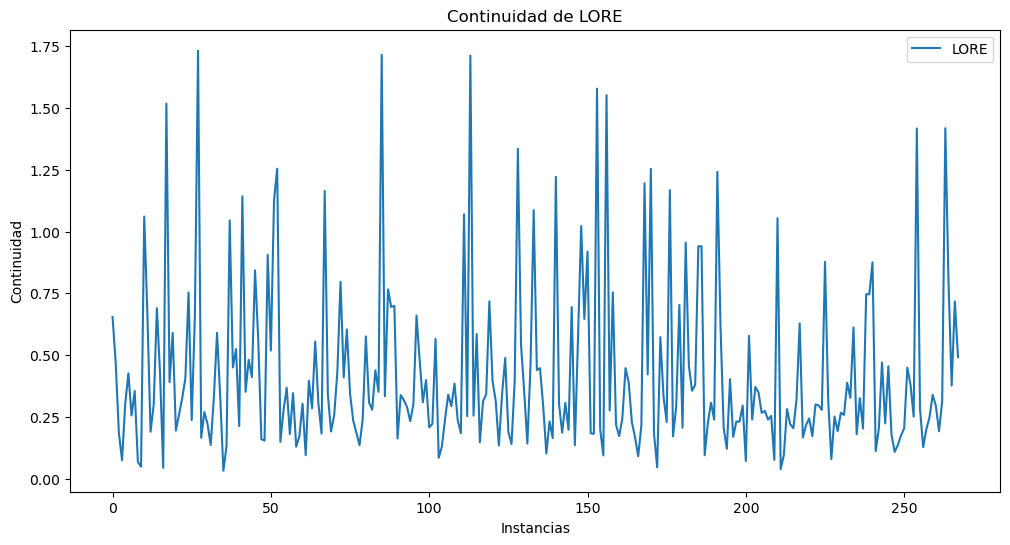

Valores de continuidad para LORE:
Instancia 0: Continuidad = 0.654794
Instancia 1: Continuidad = 0.467601
Instancia 2: Continuidad = 0.184872
Instancia 3: Continuidad = 0.074803
Instancia 4: Continuidad = 0.302713
Instancia 5: Continuidad = 0.426523
Instancia 6: Continuidad = 0.256115
Instancia 7: Continuidad = 0.354612
Instancia 8: Continuidad = 0.067452
Instancia 9: Continuidad = 0.048640
Instancia 10: Continuidad = 1.060897
Instancia 11: Continuidad = 0.666678
Instancia 12: Continuidad = 0.190208
Instancia 13: Continuidad = 0.300349
Instancia 14: Continuidad = 0.689968
Instancia 15: Continuidad = 0.424728
Instancia 16: Continuidad = 0.044001
Instancia 17: Continuidad = 1.517610
Instancia 18: Continuidad = 0.391145
Instancia 19: Continuidad = 0.589910
Instancia 20: Continuidad = 0.194560
Instancia 21: Continuidad = 0.260451
Instancia 22: Continuidad = 0.325986
Instancia 23: Continuidad = 0.407160
Instancia 24: Continuidad = 0.753586
Instancia 25: Continuidad = 0.237224
Instancia 26: 

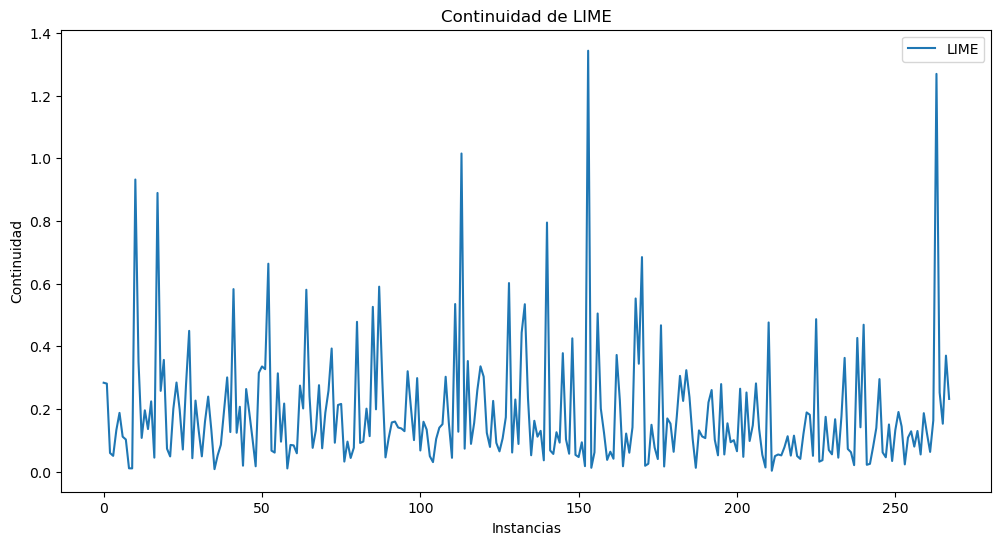

Valores de continuidad para LIME:
Instancia 0: Continuidad = 0.283721
Instancia 1: Continuidad = 0.280954
Instancia 2: Continuidad = 0.059627
Instancia 3: Continuidad = 0.050470
Instancia 4: Continuidad = 0.132585
Instancia 5: Continuidad = 0.187569
Instancia 6: Continuidad = 0.111654
Instancia 7: Continuidad = 0.102632
Instancia 8: Continuidad = 0.010694
Instancia 9: Continuidad = 0.010483
Instancia 10: Continuidad = 0.932201
Instancia 11: Continuidad = 0.350985
Instancia 12: Continuidad = 0.107693
Instancia 13: Continuidad = 0.195730
Instancia 14: Continuidad = 0.136046
Instancia 15: Continuidad = 0.224284
Instancia 16: Continuidad = 0.044790
Instancia 17: Continuidad = 0.889371
Instancia 18: Continuidad = 0.257831
Instancia 19: Continuidad = 0.356623
Instancia 20: Continuidad = 0.073258
Instancia 21: Continuidad = 0.048628
Instancia 22: Continuidad = 0.200553
Instancia 23: Continuidad = 0.284422
Instancia 24: Continuidad = 0.197955
Instancia 25: Continuidad = 0.070762
Instancia 26: 

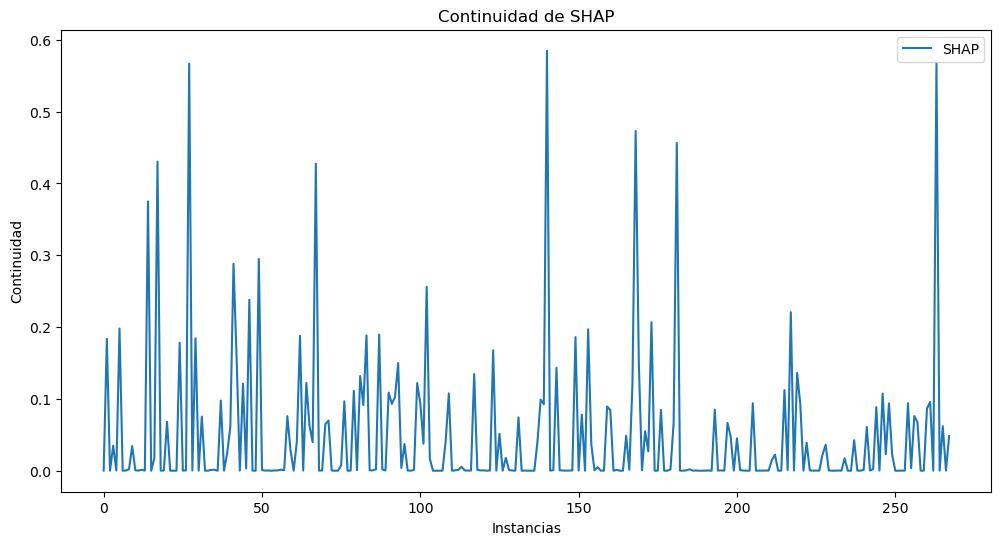

Valores de continuidad para SHAP:
Instancia 0: Continuidad = 0.000231
Instancia 1: Continuidad = 0.183684
Instancia 2: Continuidad = 0.000055
Instancia 3: Continuidad = 0.034884
Instancia 4: Continuidad = 0.000365
Instancia 5: Continuidad = 0.198036
Instancia 6: Continuidad = 0.000089
Instancia 7: Continuidad = 0.000293
Instancia 8: Continuidad = 0.002002
Instancia 9: Continuidad = 0.034287
Instancia 10: Continuidad = 0.000643
Instancia 11: Continuidad = 0.000186
Instancia 12: Continuidad = 0.001359
Instancia 13: Continuidad = 0.000167
Instancia 14: Continuidad = 0.374863
Instancia 15: Continuidad = 0.000048
Instancia 16: Continuidad = 0.017151
Instancia 17: Continuidad = 0.430509
Instancia 18: Continuidad = 0.000152
Instancia 19: Continuidad = 0.000259
Instancia 20: Continuidad = 0.068209
Instancia 21: Continuidad = 0.000056
Instancia 22: Continuidad = 0.000106
Instancia 23: Continuidad = 0.000111
Instancia 24: Continuidad = 0.178410
Instancia 25: Continuidad = 0.000132
Instancia 26: 

In [6]:
# X_perturbado = perturbar_instancias(X_test, porcentaje_ruido=0.05)
# #Importancia de las caracteristicas para LORE mediante el arbol 
# importances = dt.feature_importances_
# importance_feature_lore = dict(zip(feature_names, importances))

# importances_perturbada = exp_perturbada_lore.dt.feature_importances_
# importance_feature_lore_perturbada = dict(zip(feature_names, importances_perturbada))


# def normalizar_importancias(importancias, feature_names):
#     return {feature: importancias.get(feature, 0) for feature in feature_names}

# def comparar_importancias(importancia_original, importancia_perturbada, es_array=False):
#     if es_array:
#         # Si es un array, calcula y devuelve la diferencia absoluta media directamente
#         return np.abs(importancia_original - importancia_perturbada).mean()
#     else:
#         # Si es un diccionario, calcula la distancia como antes
#         distancia = {}
#         for feature in importancia_original:
#             distancia[feature] = np.abs(importancia_original.get(feature, 0) - importancia_perturbada.get(feature, 0))
#         return np.mean(list(distancia.values()))


# # Importancia de las características para LIME
# def calculate_lime_feature_importance(lime_explainer, x):
#     explanation = lime_explainer.explain_instance(x, bb_predict_proba)
#     feature_importance = dict(explanation.as_list())
#     return feature_importance
# lime_feature_importance = calculate_lime_feature_importance(lime_explainer,x)

# def calculate_shap_feature_importance(shap_explainer, x_instance):
#     shap_values = shap_explainer.shap_values(x_instance)
#     feature_importance = np.mean(np.abs(shap_values), axis=0)
#     return feature_importance

# def calcular_continuidad(lime_explainer, shap_explainer, x, X_perturbado):
#     continuidad_lore = []
#     continuidad_lime = []
#     continuidad_shap = []

#     for i in range(len(x)):
#         # Obtener las importancias originales y perturbadas para cada método
#         lore_orig = importance_feature_lore
#         lore_pert = importance_feature_lore_perturbada
#         lime_orig = calculate_lime_feature_importance(lime_explainer, x[i])
#         lime_pert = calculate_lime_feature_importance(lime_explainer, X_perturbado[i])
#         shap_orig = calculate_shap_feature_importance(shap_explainer, x[i])
#         shap_pert = calculate_shap_feature_importance(shap_explainer, X_perturbado[i])

#         lore_orig_array = np.array(list(lore_orig.values()))
#         lore_pert_array = np.array(list(lore_pert.values()))
#         lime_orig_array = np.array(list(lime_orig.values()))
#         lime_pert_array = np.array(list(lime_pert.values()))

#         # Calcular la continuidad según la nueva fórmula
#         continuidad_lore.append(np.linalg.norm(lore_orig_array - lore_pert_array, 1) / np.linalg.norm(x[i] - X_perturbado[i], 2))
#         continuidad_lime.append(np.linalg.norm(lime_orig_array - lime_pert_array, 1) / np.linalg.norm(x[i] - X_perturbado[i], 2))
#         continuidad_shap.append(np.linalg.norm(shap_orig - shap_pert, 1) / np.linalg.norm(x[i] - X_perturbado[i], 2))

#     return continuidad_lore, continuidad_lime, continuidad_shap


# # Función para visualizar continuidades
# def visualizar_continuidades(continuidades, metodo, titulo):
#     plt.figure(figsize=(12, 6))
#     plt.plot(continuidades, label=metodo)
#     plt.xlabel('Instancias')
#     plt.ylabel('Continuidad')
#     plt.title(titulo)
#     plt.legend()
#     plt.show()

#     # Imprimir valores de continuidad
#     print(f"Valores de continuidad para {metodo}:")
#     for i, valor in enumerate(continuidades):
#         print(f"Instancia {i}: Continuidad = {valor:.6f}")
        
# # Llamada a la función y visualización
# continuidad_lore, continuidad_lime, continuidad_shap = calcular_continuidad(lime_explainer, shap_explainer, X_test, X_perturbado)
# visualizar_continuidades(continuidad_lore, "LORE", "Continuidad de LORE")
# visualizar_continuidades(continuidad_lime, "LIME", "Continuidad de LIME")
# visualizar_continuidades(continuidad_shap, "SHAP", "Continuidad de SHAP")

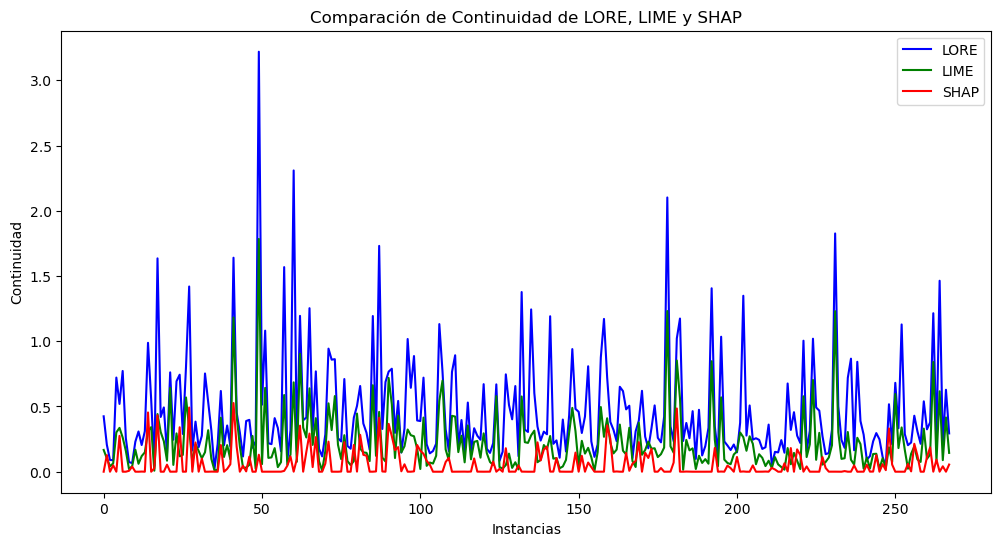

In [5]:
X_perturbado = perturbar_instancias(X_test, porcentaje_ruido=0.05)
#Importancia de las caracteristicas para LORE mediante el arbol 
importances = dt.feature_importances_
importance_feature_lore = dict(zip(feature_names, importances))

importances_perturbada = exp_perturbada_lore.dt.feature_importances_
importance_feature_lore_perturbada = dict(zip(feature_names, importances_perturbada))


def normalizar_importancias(importancias, feature_names):
    return {feature: importancias.get(feature, 0) for feature in feature_names}

def comparar_importancias(importancia_original, importancia_perturbada, es_array=False):
    if es_array:
        # Si es un array, calcula y devuelve la diferencia absoluta media directamente
        return np.abs(importancia_original - importancia_perturbada).mean()
    else:
        # Si es un diccionario, calcula la distancia como antes
        distancia = {}
        for feature in importancia_original:
            distancia[feature] = np.abs(importancia_original.get(feature, 0) - importancia_perturbada.get(feature, 0))
        return np.mean(list(distancia.values()))


# Importancia de las características para LIME
def calculate_lime_feature_importance(lime_explainer, x):
    explanation = lime_explainer.explain_instance(x, bb_predict_proba)
    feature_importance = dict(explanation.as_list())
    return feature_importance
lime_feature_importance = calculate_lime_feature_importance(lime_explainer,x)

def calculate_shap_feature_importance(shap_explainer, x_instance):
    shap_values = shap_explainer.shap_values(x_instance)
    feature_importance = np.mean(np.abs(shap_values), axis=0)
    return feature_importance

def calcular_continuidad(lime_explainer, shap_explainer, x, X_perturbado):
    continuidad_lore = []
    continuidad_lime = []
    continuidad_shap = []

    for i in range(len(x)):
        # Obtener las importancias originales y perturbadas para cada método
        lore_orig = importance_feature_lore
        lore_pert = importance_feature_lore_perturbada
        lime_orig = calculate_lime_feature_importance(lime_explainer, x[i])
        lime_pert = calculate_lime_feature_importance(lime_explainer, X_perturbado[i])
        shap_orig = calculate_shap_feature_importance(shap_explainer, x[i])
        shap_pert = calculate_shap_feature_importance(shap_explainer, X_perturbado[i])

        lore_orig_array = np.array(list(lore_orig.values()))
        lore_pert_array = np.array(list(lore_pert.values()))
        lime_orig_array = np.array(list(lime_orig.values()))
        lime_pert_array = np.array(list(lime_pert.values()))

        # Calcular la continuidad según la nueva fórmula
        continuidad_lore.append(np.linalg.norm(lore_orig_array - lore_pert_array, 1) / np.linalg.norm(x[i] - X_perturbado[i], 2))
        continuidad_lime.append(np.linalg.norm(lime_orig_array - lime_pert_array, 1) / np.linalg.norm(x[i] - X_perturbado[i], 2))
        continuidad_shap.append(np.linalg.norm(shap_orig - shap_pert, 1) / np.linalg.norm(x[i] - X_perturbado[i], 2))

    return continuidad_lore, continuidad_lime, continuidad_shap


# Función para visualizar continuidades
def visualizar_continuidades_comparativas(continuidades, metodos, titulo):
    plt.figure(figsize=(12, 6))
    colores = ['blue', 'green', 'red']  # Define colores para cada método

    for i, metodo in enumerate(metodos):
        plt.plot(continuidades[i], label=metodo, color=colores[i])

    plt.xlabel('Instancias')
    plt.ylabel('Continuidad')
    plt.title(titulo)
    plt.legend()
    plt.show()
    

# Llamada a la función y visualización
continuidad_lore, continuidad_lime, continuidad_shap = calcular_continuidad(lime_explainer, shap_explainer, X_test, X_perturbado)
visualizar_continuidades_comparativas([continuidad_lore, continuidad_lime, continuidad_shap], ["LORE", "LIME", "SHAP"], "Comparación de Continuidad de LORE, LIME y SHAP")

